In [1]:
import torch
import torch.nn as nn
import torchaudio
from timit_utils import preprocess, Timit 

# autoreload
%load_ext autoreload
%autoreload 2

In [3]:
dataset = Timit('timit') # small subset (from kaggle)
path, wav, transcript, _, target = dataset[0]

/home/annareisz/miniconda3/envs/dlsp/lib/python3.11/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


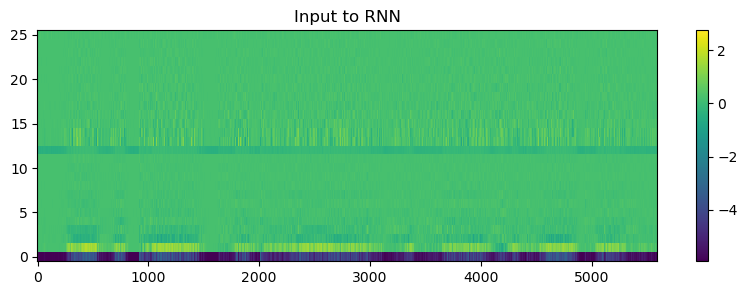

In [4]:
# plot wav as spectorgram
import matplotlib.pyplot as plt

features = preprocess(wav)

# add log energy
plt.figure(figsize=(10, 3))
plt.imshow(features.squeeze(0), aspect='auto', origin='lower', interpolation='none')
plt.title("Input to RNN")

#colorbar
cbar = plt.colorbar()
plt.show()

In [5]:
class CTCModel(nn.Module):
    def __init__(self, num_classes=62):
        super(CTCModel, self).__init__()
        self.lstm = nn.LSTM(input_size=26, hidden_size=num_classes, num_layers=1, batch_first=True, 
                            bidirectional=True)
        self.output = nn.Linear(2*num_classes, num_classes)
        self.softmax = nn.LogSoftmax(dim=2)
        self.num_classes = num_classes # num phonemes + 1 (for blank)

    def forward(self, x):
        out, _ = self.lstm(x)
        logits = self.output(out)
        y = self.softmax(logits)
        return y
    
model = CTCModel()
y = model(features.permute(0, 2, 1))
print(y.shape)

torch.Size([1, 5594, 62])


In [6]:
# pytorch implementation

input_lengths = torch.full(size=(1,), fill_value=y.shape[1], dtype=torch.long)
target_lengths = torch.tensor([target.shape[-1]])
criterion = nn.CTCLoss()
criterion(y.permute(1, 0, 2), target.unsqueeze(0), input_lengths, target_lengths)


tensor(548.1757, grad_fn=<MeanBackward0>)

In [77]:
# from scratch implementation
import numpy as np
y = np.array([[0.1, 0.2, 0.1, 0.4, 0.6], # p(blank | x)
              [0.7, 0.3, 0.1, 0.3, 0.2], # p(l1 | x)
              [0.1, 0.1, 0.4, 0.2, 0.1], # p(l2 | x)
              [0.1, 0.4, 0.4, 0.1, 0.1], # p(l3 | x)
              ]) 
#              t=1  t=2  t=3  t=4  t=5

labels = [1, 0, 2, 1] 

def forward(y, l, blank_idx=0, normalize=True):
    #alpha_t(s) is alpha[s, t]
    V, T = y.shape
    lenl_prime = 2*len(l) + 1
    # insert every other label with a blank
    l_prime = [blank_idx] + [l[i//2] if i % 2 == 1 else blank_idx for i in range(1, lenl_prime)] #TODO: vectorize
    alpha = np.zeros((lenl_prime, T))
    # Initialization
    alpha[0, 0] = y[blank_idx, 0] # blank at t=0
    alpha[1, 0] = y[l[0], 0] # first phoneme at t=0
    
    # Recursion
    for t in range(1, T):
        for s in range(lenl_prime):
            
            if s < lenl_prime - 2*(T-t) - 1:
                continue

            alpha_bar = alpha[s, t-1] + alpha[s-1, t-1]

            if l_prime[s] == blank_idx or l_prime[s-2] == l_prime[s]:
                alpha[s, t] = alpha_bar * y[l_prime[s], t]
            else:
                alpha[s, t] = (alpha_bar + alpha[s-2, t-1]) * y[l_prime[s], t]

            if normalize:
                C = np.sum(alpha[:, t])
                alpha[s, t] = alpha[s, t] / C # alpha_hat_t(s)
    
    return alpha

def backward(y, l, blank_idx=0, normalize=True):
    V, T = y.shape
    lenl_prime = 2*len(l) + 1
    # insert every other label with a blank
    l_prime = [blank_idx] + [l[i//2] if i % 2 == 1 else blank_idx for i in range(1, lenl_prime)] #TODO: vectorize
    beta = np.zeros((lenl_prime, T))

    # Initialization
    beta[lenl_prime-1, T-1] = y[blank_idx, T-1] # blank at t=T
    beta[lenl_prime-2, T-1] = y[l[-1], T-1] # last phoneme at t=T

    # Recursion
    for t in range(T-2, -1, -1):
        for s in range(lenl_prime):

            if s > 2*t:
                continue

            beta_bar = beta[s, t+1] + beta[s+1, t+1]

            if l_prime[s] == blank_idx or l_prime[s+2] == l_prime[s]:
                beta[s, t] = beta_bar * y[l_prime[s], t]
            else:
                beta[s, t] = (beta_bar + beta[s+2, t+1]) * y[l_prime[s], t]

            if normalize:
                D = np.sum(beta[:, t])
                beta[s, t] = beta[s, t] / (D + 1e-20)

    return beta




def compute_ctc_loss(y, l, t, blank_idx=0): # do we do this for all t's or what?
    alpha = forward(y, l, blank_idx)
    beta = backward(y, l, blank_idx)
    lenl_prime = 2*len(l) + 1
    l_prime = [blank_idx] + [l[i//2] if i % 2 == 1 else blank_idx for i in range(1, lenl_prime)] #TODO: vectorize
    probabilities = alpha * beta
    probabilities_t = probabilities[:, t]
    print(probabilities_t)

    p_l_x = np.sum(probabilities_t / y[l_prime, t])

    return np.log(p_l_x)

compute_ctc_loss(y, labels, -1)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.29071764e-05
 0.00000000e+00]


-7.788351019734566